### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical as make_class_categorical
import _pickle as pickle
from tqdm import tqdm
import pdb
import skimage as sk
from skimage import util
from keras.preprocessing.image import ImageDataGenerator
import random

Using TensorFlow backend.


### Assignment 2 functions

#### Initialize weights

In [2]:
def initialize_weights(d=3072, m=50, K=10, std=0.001):
    """
    Initializes the weight and bias arrays for the 2 layers of the network

    :param d: Dimensionality of the input data
    :param m: Number of nodes in the first layer
    :param K: Number of different classes (K=10 for the CIFAR-10 dataset)
    :param variance (optional): The variance of the normal distribution that will be used for the initialization of the weights

    :return: Weights and bias arrays for the first and second layer of the neural network
    """

    np.random.seed(400)

    W1 = np.random.normal(0, std, size=(m, d))
    b1 = np.zeros(shape=(m, 1))

    W2 = np.random.normal(0, std, size=(K, m))
    b2 = np.zeros(shape=(K, 1))

    return W1, b1, W2, b2

In [3]:
def he_initialization(d=3072, m=50, K=10):
    """
    He initialization on the weight matrices.

    :param d: Dimensionality of input data.
    :param m: Number of nodes in the hidden layer.
    :param K: Number of classes.

    :return: Initialized weight and bias matrices based on He initialization of the weights.
    """
    np.random.seed(400)

    W1 = np.random.randn(m, d) * np.sqrt(2 / float(m))
    W2 = np.random.randn(K, m) * np.sqrt(2 / float(K))

    b1 = np.zeros(shape=(m, 1))
    b2 = np.zeros(shape=(K, 1))

    return W1, b1, W2, b2

#### Load Batch

In [4]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

#### ReLU's

In [5]:
def ReLU(x):
    """
    Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(x, 0)

In [6]:
def Leaky_ReLU(x):
    """
    Leaky Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(0.01*x, x)

#### Softmax

In [7]:
def softmax(X, theta=1.0, axis=None):

    # Softmax over numpy rows and columns, taking care for overflow cases
    # Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    # Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

#### Evaluate Classifier

In [8]:
def EvaluateClassifier(X, W1, b1, W2, b2, with_leaky_relu= False):
    """
    Computes the Softmax output of the 2 layer network, based on input data X and trained weight and bias arrays

    :param X: Input data
    :param W1: Weight array of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight array of the second layer
    :param b2: Bias vector of the second layer

    :return: Softmax output of the trained network
    """

    s1 = np.dot(W1, X) + b1
    if not with_leaky_relu:
        h = ReLU(s1)
    else:
        h = Leaky_ReLU(s1)
    s = np.dot(W2, h) + b2
    p = softmax(s, axis=0)

    return p, h, s1

#### Predict classes

In [9]:
def predictClasses(p):
    """
    Predicts classes based on the softmax output of the network

    :param p: Softmax output of the network
    :return: Predicted classes
    """

    return np.argmax(p, axis=0)

#### Compute Accuracy

In [10]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    """
    Computes the accuracy of the feed-forward 2-layer network

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer

    :return: Accuracy metric of the neural network.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

#### Compute Cost

In [11]:
def ComputeCost(X, Y, W1, W2, b1, b2, regularization_term= 0):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param regularization_term: Amount of regularization applied.

    :return: Cross-entropy loss.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = np.power(W1, 2).sum() + np.power(W2, 2).sum()

    return cross_entropy_loss + regularization_term * weight_sum

#### Compute Gradients

In [34]:
def ComputeGradients(X, Y, W1, b1, W2, b2, p, h, s1, regularization_term= 0, with_leaky_relu= False):
    """
    Computes gradient descent updates on a batch of data

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param p: Softmax probabilities (predictions) of the network over classes.
    :param h: ReLU activations of the network.
    :param s1: True outout of the first layer of the network.
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network
    """

    # Back-propagate second layer at first

    g = p - Y
    grad_b2 = g.sum(axis=1).reshape(b2.shape)
    grad_W2 = np.dot(g, h.T)

    # Back-propagate the gradient vector g to the first layer
    g = np.dot(g.T, W2)
    if with_leaky_relu:
        ind =(1 * (s1 > 0) + 0.01 * (s1 < 0))
    else:
        ind = 1 * (s1 > 0)
    g = g.T * ind

    grad_b1 = np.sum(g, axis=1).reshape(b1.shape)
    grad_W1 = np.dot(g, X.T)

    grad_W1 /= X.shape[1]
    grad_b1 /= X.shape[1]
    grad_W2 /= X.shape[1]
    grad_b2 /= X.shape[1]

    # Add regularizers
    grad_W1 = grad_W1 + 2 * regularization_term * W1
    grad_W2 = grad_W2 +2 * regularization_term * W2

    return grad_W1, grad_b1, grad_W2, grad_b2

#### Momentum Update

In [16]:
def initialize_momentum(hyperparameter):
    """
    Initializes the corresponding momentum of a hyperparameter matrix or vector

    :param hyperparameter: The hyperparameter
    :return: The corresponding momentum
    """

    return np.zeros(hyperparameter.shape)

In [17]:
def add_momentum(v_t_prev, hyperpatameter, gradient, eta, momentum_term=0.99):
    """
    Add momentum to the update of the hyperparameter at each update step, in order to speed up training

    :param v_t_prev: The momentum update of the previous time step
    :param hyperpatameter: The corresponding hyperparameters
    :param gradient: The value of the gradient update as computed in each time step
    :param eta: The learning rate of the training process
    :param r (optional): The momentum factor, typically 0.9 or 0.99

    :return: The updated hyperparameter based on the momentum update, and the  momentum update itself
    """

    v_t = momentum_term * v_t_prev + eta * gradient

    return hyperpatameter - v_t, v_t



#### Mini-Batch Gradient Descent

In [25]:
def MiniBatchGDwithMomentum(X, Y, X_validation, Y_validation, y_validation, GDparams, W1, b1, W2, b2,
                            regularization_term=0, with_annealing = False, with_leaky_relu= False, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param W1: Weight matrix of the first layer of the network.
    :param b1: Bias vector of the first layer of the network.
    :param W2: Weight matrix of the second layer of the network.
    :param b2: Bias vector of the second layer of the network.
    :param regularization_term: Amount of regularization applied.
    :param with_annealing: Set to true to allow decaying the learning rate by half every 5 epochs.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    v_W1 = initialize_momentum(W1)
    v_b1 = initialize_momentum(b1)
    v_W2 = initialize_momentum(W2)
    v_b2 = initialize_momentum(b2)

    # print('Training set loss before start of training process: '+str(ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)))

    original_training_cost = ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)

    best_W1 = np.copy(W1)
    best_b1 = np.copy(b1)
    best_W2 = np.copy(W2)
    best_b2 = np.copy(b2)

    best_validation_set_accuracy = 0

    for epoch in tqdm(range(epoches)):
        # for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, h, s1 = EvaluateClassifier(X[:, start:end], W1, b1, W2, b2, with_leaky_relu)

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:, start:end], Y[:, start:end], W1, b1, W2, b2, p,
                                                                  h, s1, regularization_term, with_leaky_relu)

            W1, v_W1 = add_momentum(v_W1, W1, grad_W1, eta, momentum_term)
            b1, v_b1 = add_momentum(v_b1, b1, grad_b1, eta, momentum_term)
            W2, v_W2 = add_momentum(v_W2, W2, grad_W2, eta, momentum_term)
            b2, v_b2 = add_momentum(v_b2, b2, grad_b2, eta, momentum_term)

        validation_set_accuracy = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)

        if validation_set_accuracy > best_validation_set_accuracy:
            best_W1 = np.copy(W1)
            best_b1 = np.copy(b1)
            best_W2 = np.copy(W2)
            best_b2 = np.copy(b2)

            best_validation_set_accuracy = validation_set_accuracy

        epoch_cost = ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)
        # print('Training set loss after epoch number '+str(epoch)+' is: '+str(epoch_cost))
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost = ComputeCost(X_validation, Y_validation, W1, W2, b1, b2, regularization_term)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

        # Decay the learning rate
        if with_annealing:
            if epoch > 1 and epoch // 5 == 0:
                eta /= 2.0
        else:
            eta *= 0.95

    # return W1, b1, W2, b2, cost, val_cost
    return best_W1, best_b1, best_W2, best_b2, cost, val_cost

#### Visualizing functions

In [18]:
def visualize_costs(loss, val_loss, display= False, title = None, save_name= None, save_path='../figures/'):
    """
    Visualization and saving the losses of the network.

    :param loss: Loss of the network.
    :param val_loss: Loss of the network in the validation set.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(loss, 'g', label='Training set ')
    plt.plot(val_loss, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] !='/':
            save_path+='/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

In [19]:
def visualize_raw_image(image_array, display=True):
    img = image_array.reshape(3,32,32).transpose([1, 2, 0])
    if display:
        plt.imshow(img)

#### Create dataset function

In [20]:
def create_sets():

    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_training_3, Y_training_3, y_training_3 = LoadBatch('../../cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch('../../cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch('../../cifar-10-batches-py/data_batch_5')

    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))

    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))

    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)

    y_training = y_training_1 + y_training_3 + y_training_4 + y_training_5 + y_training_2[:9000]

    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]

    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training)
    X_training -= mean
    X_validation -= mean
    X_test -= mean

    return [X_training, Y_training, y_training], [X_validation, Y_validation, y_validation], [X_test, y_test]


In [21]:
training, validation, test = create_sets()

X_training, Y_training, y_training = training
X_validation, Y_validation, y_validation = validation
X_test, y_test = test

#### Image augmentation function

In [22]:
def random_noise(image_array):
    return sk.util.random_noise(image_array)

In [23]:
def create_augmented_dataset(X, y):
    
    X_augmented = np.zeros(X.shape)
    
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator( 
        rotation_range=90, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True) 

    data = np.ndarray(shape=(X.shape[1], 32, 32, 3))
    for datum in range(X.shape[1]):
        data[datum, :] = X[:, datum].reshape(3, 32, 32).transpose(1, 2, 0)
        for X_batch, _ in datagen.flow(data[datum:datum+1], y[datum:datum+1], batch_size=1):
            X_augmented[:, datum] = X_batch[0].transpose(2, 1, 0).reshape(3072)
            break

    return X_augmented

In [24]:
def jitter_batch(X, y):
    """
    Jitters a batch of images
    """

    X_jittered = create_augmented_dataset(X, y)

    # With probability 50% we add random noise to an image along with other permutations
    for datum in range(X_jittered.shape[1]):
        add_noise = random.random()
        if add_noise > 0.5:
            X_jittered[:,datum] = random_noise(X_jittered[:,datum])

    return X_jittered

In [26]:
def MiniBatchGDwithAugmenting(X, Y, X_validation, Y_validation, y_training, y_validation, GDparams, W1, b1, W2, b2,
                            regularization_term=0, with_annealing = False, with_leaky_relu= False, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations on augmented images.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param y_training: True labels of the training data.
    :param y_validation: True labels of the validation data. 
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param W1: Weight matrix of the first layer of the network.
    :param b1: Bias vector of the first layer of the network.
    :param W2: Weight matrix of the second layer of the network.
    :param b2: Bias vector of the second layer of the network.
    :param regularization_term: Amount of regularization applied.
    :param with_annealing: Set to true to allow decaying the learning rate by half every 5 epochs.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    v_W1 = initialize_momentum(W1)
    v_b1 = initialize_momentum(b1)
    v_W2 = initialize_momentum(W2)
    v_b2 = initialize_momentum(b2)

    # print('Training set loss before start of training process: '+str(ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)))

    original_training_cost = ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)

    best_W1 = np.copy(W1)
    best_b1 = np.copy(b1)
    best_W2 = np.copy(W2)
    best_b2 = np.copy(b2)

    best_validation_set_accuracy = 0

    for epoch in tqdm(range(epoches)):
        # for epoch in range(epoches):
        
        # augmented_X = np.copy(jitter_batch(X, y_training))
        augmented_X = np.copy(random_noise(X))

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, h, s1 = EvaluateClassifier(augmented_X[:, start:end], W1, b1, W2, b2, with_leaky_relu)

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(augmented_X[:, start:end], Y[:, start:end], W1, b1, W2, b2, p,
                                                                  h, s1, regularization_term, with_leaky_relu)

            W1, v_W1 = add_momentum(v_W1, W1, grad_W1, eta, momentum_term)
            b1, v_b1 = add_momentum(v_b1, b1, grad_b1, eta, momentum_term)
            W2, v_W2 = add_momentum(v_W2, W2, grad_W2, eta, momentum_term)
            b2, v_b2 = add_momentum(v_b2, b2, grad_b2, eta, momentum_term)

        validation_set_accuracy = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)

        if validation_set_accuracy > best_validation_set_accuracy:
            best_W1 = np.copy(W1)
            best_b1 = np.copy(b1)
            best_W2 = np.copy(W2)
            best_b2 = np.copy(b2)

            best_validation_set_accuracy = validation_set_accuracy

        epoch_cost = ComputeCost(augmented_X, Y, W1, W2, b1, b2, regularization_term)
        # print('Training set loss after epoch number '+str(epoch)+' is: '+str(epoch_cost))
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost = ComputeCost(X_validation, Y_validation, W1, W2, b1, b2, regularization_term)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

        # Decay the learning rate
        if with_annealing:
            if epoch > 1 and epoch // 5 == 0:
                eta /= 2.0
        else:
            eta *= 0.95

    # return W1, b1, W2, b2, cost, val_cost
    return best_W1, best_b1, best_W2, best_b2, cost, val_cost

## Bonus point part

### Exercise 1: Optimize the performance of the network

#### Improvement 1: Keep track of the best model based on validation set performance along with training for more steps

In [1]:
def improvement_1(eta, regularization_term):
    """
     Use all the available data from training, train for more update steps and use your validation set to make 
    sure you don’t overfit or keep a record of the best model before you begin to overfit

    :return: Learnt weight matrices, training and validation set loss evolution 
    """

    W1, b1, W2, b2 = initialize_weights()

    GD_params = [100, eta, 50]

    W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1, b1, W2, b2,
                                                                                     regularization_term)

    return W1, b1, W2, b2, training_set_loss, validation_set_loss

In [125]:
W1_improvement_1, b1_improvement_1, W2_improvement_1, b2_improvement_1, training_set_loss_improvement_1, validation_set_loss_improvement_1 = improvement_1(eta=0.02878809988519304, regularization_term=0.001)


100%|██████████| 40/40 [52:48<00:00, 79.21s/it]


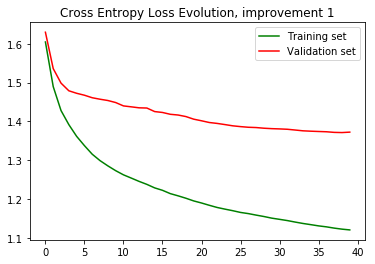

<Figure size 432x288 with 0 Axes>

In [126]:
visualize_costs(training_set_loss_improvement_1, validation_set_loss_improvement_1, display=True,
                title='Cross Entropy Loss Evolution, improvement 1', save_name='improvement_1')

In [29]:
accuracy_improvement_1 = ComputeAccuracy(X_test, y_test, W1_improvement_1, b1_improvement_1, W2_improvement_1, b2_improvement_1)

NameError: name 'W1_improvement_1' is not defined

The accuracy of the first improvement for $\eta=0.02878809988519304$ and $\lambda=0.001$ is $51.53\%$

In [128]:
accuracy_improvement_1

51.53

We will also try the first setting with this improvement so that we can define a pair for $(\eta, \lambda)$ that has the best test set accuracy performance and use it for other improvements

In [27]:
W1_improvement_1_2, b1_improvement_1_2, W2_improvement_1_2, b2_improvement_1_2, training_set_loss_improvement_1_2, validation_set_loss_improvement_1_2 = improvement_1(eta=0.018920249916784752, regularization_term=0.0001)

100%|██████████| 50/50 [1:04:20<00:00, 77.21s/it]


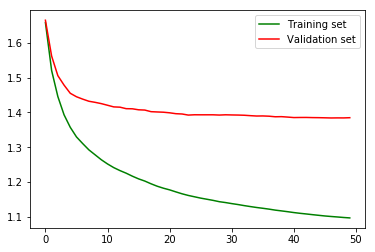

<Figure size 432x288 with 0 Axes>

In [33]:
visualize_costs(training_set_loss_improvement_1_2, validation_set_loss_improvement_1_2, display=True, save_name='Improvement_1_2')

In [ ]:
accuracy_improvement_1_2 = ComputeAccuracy(X_test, y_test, W1_improvement_1_2, b1_improvement_1_2, W2_improvement_1_2, b2_improvement_1_2)

The accuracy of this setting for the first improvement is $51.94\%$

In [31]:
accuracy_improvement_1_2

51.94

Try no.3: Same settings, smaller amount of regularization

In [53]:
W1_improvement_1_3, b1_improvement_1_3, W2_improvement_1_3, b2_improvement_1_3, training_set_loss_improvement_1_3, validation_set_loss_improvement_1_3 = improvement_1(eta=0.018920249916784752, regularization_term=0.0001)

100%|██████████| 50/50 [1:02:45<00:00, 75.30s/it]


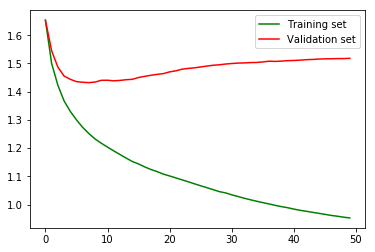

<Figure size 432x288 with 0 Axes>

In [58]:
visualize_costs(training_set_loss_improvement_1_3, validation_set_loss_improvement_1_3, display=True, save_name='Improvement_1_3')

In [59]:
accuracy_improvement_1_3 = ComputeAccuracy(X_test, y_test, W1_improvement_1_3, b1_improvement_1_3, W2_improvement_1_3, b2_improvement_1_3)

The accuracy performance of this setting is 49.94%

In [60]:
accuracy_improvement_1_3

49.94

#### Improvement 2: Switch to He initialization and see the effect it has on training. 

In [44]:
def improvement_2(eta=0.018920249916784752, regularization_term=0.001):
    """
    Switch to He-initialization
    """
    W1_he, b1_he, W2_he, b2_he = he_initialization()

    GD_params = [100, eta, 40]

    W1_he, b1_he, W2_he, b2_he, training_set_loss_he, validation_set_loss_he = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1_he, b1_he, W2_he, b2_he,
                                                                                     regularization_term)

    return W1_he, b1_he, W2_he, b2_he, training_set_loss_he, validation_set_loss_he

In [45]:
W1_improvement_2, b1_improvement_2, W2_improvement_2, b2_improvement_2, \
training_set_loss_improvement_2, validation_set_loss_improvement_2 = improvement_2()

100%|██████████| 40/40 [51:06<00:00, 76.67s/it]


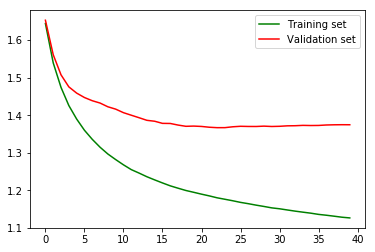

<Figure size 432x288 with 0 Axes>

In [48]:
visualize_costs(training_set_loss_improvement_2, validation_set_loss_improvement_2, display=True, save_name='Improvement_1_2')

In [49]:
accuracy_improvement_2 = ComputeAccuracy(X_test, y_test, W1_improvement_2, b1_improvement_2, W2_improvement_2, b2_improvement_2)

The accuracy of this setting is 51.44%

In [50]:
accuracy_improvement_2

51.44

#### Improvement 3: You could also explore whether having more hidden nodes improves the final classification rate. One would expect that with more hidden nodes then the amount of regularization would have to increase.

In [63]:
def improvement_3(eta=0.018920249916784752, regularization_term=0.001):
    """
     You could also explore whether having more hidden nodes improves the final classification rate. 
    One would expect that with more hidden nodes then the amount of regularization would have to increase.
    """

    W1_100, b1_100, W2_100, b2_100 = initialize_weights(m=100)

    GD_params = [100, eta, 30]

    W1_100, b1_100, W2_100, b2_100, training_set_loss_100, validation_set_loss_100 = MiniBatchGDwithMomentum(X_training,
                                                                                     Y_training,
                                                                                     X_validation,
                                                                                     Y_validation,
                                                                                     y_validation,
                                                                                     GD_params,
                                                                                     W1_100, b1_100, W2_100, b2_100,
                                                                                     regularization_term)

    return W1_100, b1_100, W2_100, b2_100, training_set_loss_100, validation_set_loss_100

In [64]:
W1_improvement_3, b1_improvement_3, W3_improvement_3, b3_improvement_3, \
training_set_loss_improvement_3, validation_set_loss_improvement_3 = improvement_3()

100%|██████████| 30/30 [37:43<00:00, 75.45s/it]


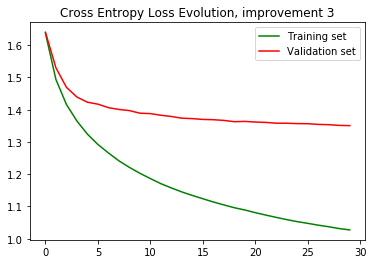

<Figure size 432x288 with 0 Axes>

In [65]:
visualize_costs(training_set_loss_improvement_3, validation_set_loss_improvement_3, display=True,
                title='Cross Entropy Loss Evolution, improvement 3', save_name='improvement_3')

In [66]:
accuracy_improvement_3 = ComputeAccuracy(X_test, y_test, W1_improvement_3, b1_improvement_3, W3_improvement_3, b3_improvement_3)

The accuracy achieved is 53.48%

In [67]:
accuracy_improvement_3

53.48

#### Improvement 4: Play around with different approaches to anneal the learning rate. For example you can keep the learning rate fixed over several epochs then decay it by a factor of 10 after n epochs.

In [68]:
    def improvement_4(eta=0.018920249916784752, regularization_term=0.001):
        """
        ﻿Play around with different approaches to anneal the learning rate.
        For example you can keep the learning rate fixed over several epochs then decay it by a factor of 10 after n epochs.
        """
        
        W1_annealing, b1_annealing, W2_annealing, b2_annealing = initialize_weights()
        
        GD_params = [100, eta, 30]

        W1_annealing, b1_annealing, W2_annealing, b2_annealing, training_set_loss_annealing, validation_set_loss_annealing = \
            MiniBatchGDwithMomentum( X_training,
                                     Y_training,
                                     X_validation,
                                     Y_validation,
                                     y_validation,
                                     GD_params,
                                     W1_annealing, b1_annealing, W2_annealing, b2_annealing,
                                     regularization_term,
                                     with_annealing=True)

        return W1_annealing, b1_annealing, W2_annealing, b2_annealing, training_set_loss_annealing, validation_set_loss_annealing

In [69]:
W1_improvement_4, b1_improvement_4, W4_improvement_4, b4_improvement_4, \
training_set_loss_improvement_4, validation_set_loss_improvement_4 = improvement_4()

100%|██████████| 30/30 [36:44<00:00, 73.49s/it]


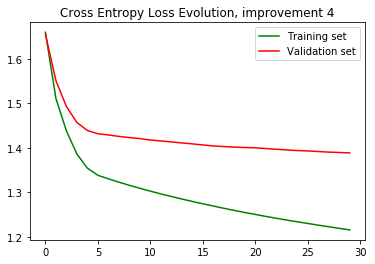

<Figure size 432x288 with 0 Axes>

In [70]:
visualize_costs(training_set_loss_improvement_4, validation_set_loss_improvement_4, display=True,
                title='Cross Entropy Loss Evolution, improvement 4', save_name='improvement_4')

In [71]:
accuracy_improvement_4 = ComputeAccuracy(X_test, y_test, W1_improvement_4, b1_improvement_4, W4_improvement_4, b4_improvement_4)

Test set accuracy performance achieved: 51.34%

In [72]:
accuracy_improvement_4

51.34

#### Improvement 5: Augmenting the training data on the fly, applying random transformations to them before doing the forward and backward pass

In [184]:
def improvement_5(eta=0.018920249916784752, regularization_term=0.001):
    """
    Apply random transformations to the images.
    """

    W1_jittering, b1_jittering, W2_jittering, b2_jittering = initialize_weights()

    GD_params = [100, eta, 30]

    W1_jittering, b1_jittering, W2_jittering, b2_jittering, training_set_loss_jittering, validation_set_loss_jittering = \
        MiniBatchGDwithAugmenting(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_training,  
                                y_validation,
                                GD_params,
                                W1_jittering, b1_jittering, W2_jittering, b2_jittering,
                                regularization_term)

    return W1_jittering, b1_jittering, W2_jittering, b2_jittering, training_set_loss_jittering, validation_set_loss_jittering



  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [02:18<1:06:43, 138.05s/it]

  7%|▋         | 2/30 [04:37<1:04:50, 138.93s/it]

 10%|█         | 3/30 [06:56<1:02:27, 138.80s/it]

 13%|█▎        | 4/30 [09:17<1:00:25, 139.43s/it]

 17%|█▋        | 5/30 [11:25<57:07, 137.09s/it]  

 20%|██        | 6/30 [13:42<54:50, 137.12s/it]

 23%|██▎       | 7/30 [15:52<52:08, 136.00s/it]

 27%|██▋       | 8/30 [17:56<49:21, 134.59s/it]

 30%|███       | 9/30 [20:06<46:54, 134.03s/it]

 33%|███▎      | 10/30 [22:21<44:42, 134.10s/it]

 37%|███▋      | 11/30 [24:29<42:18, 133.58s/it]

 40%|████      | 12/30 [26:37<39:56, 133.11s/it]

 43%|████▎     | 13/30 [28:51<37:44, 133.21s/it]

 47%|████▋     | 14/30 [30:52<35:17, 132.35s/it]

 50%|█████     | 15/30 [33:06<33:06, 132.43s/it]

 53%|█████▎    | 16/30 [35:27<31:01, 132.97s/it]

 57%|█████▋    | 17/30 [37:41<28:49, 133.02s/it]

 60%|██████    | 18/30 [39:49<26:33, 132.75s/it]

 63%|██████▎   | 19/30 [42:02<24:20, 132.74s/it]

 67%|██

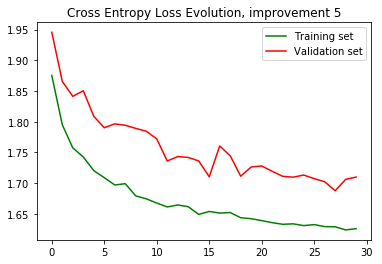

<Figure size 432x288 with 0 Axes>

In [185]:
W1_improvement_5, b1_improvement_5, W2_improvement_5, b2_improvement_5, \
training_set_loss_improvement_5, validation_set_loss_improvement_5 = improvement_5()

visualize_costs(training_set_loss_improvement_5, validation_set_loss_improvement_5, display=True,
                title='Cross Entropy Loss Evolution, improvement 5', save_name='improvement_5')

In [186]:
accuracy_improvement_5 = ComputeAccuracy(X_test, y_test, W1_improvement_5, b1_improvement_5, W2_improvement_5, b2_improvement_5)

Test set accuracy  performance: 40.35%

In [187]:
accuracy_improvement_5

40.35

### Exercise 2: Train network using a different activation to ReLu 

We make use of the leaky ReLu function in order to observe any possible differences in the training process

First try:

In [42]:
def try_1(eta=0.018920249916784752, regularization_term=0.001):

    W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1 = initialize_weights()

    GD_params = [100, eta, 30]

    W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1, training_set_loss_leaky_1, validation_set_loss_leaky_1 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1,
                                regularization_term,
                                with_leaky_relu=True)

    return W1_leaky_1, b1_leaky_1, W2_leaky_1, b2_leaky_1, training_set_loss_leaky_1, validation_set_loss_leaky_1

In [43]:
W1_try_1, b1_try_1, W2_try_1, b2_try_1, \
training_set_loss_try_1, validation_set_loss_try_1 = try_1()


100%|██████████| 30/30 [44:18<00:00, 88.62s/it]


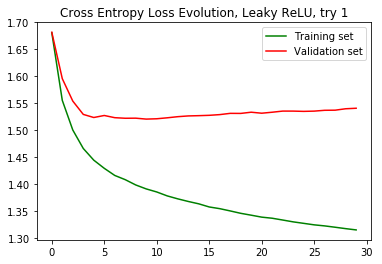

<Figure size 432x288 with 0 Axes>

In [44]:
visualize_costs(training_set_loss_try_1, validation_set_loss_try_1, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 1', save_name='try_1')

In [45]:
accuracy_try_1 = ComputeAccuracy(X_test, y_test, W1_try_1, b1_try_1, W2_try_1, b2_try_1)

Test set accuracy performance: 51.53%

In [46]:
accuracy_try_1

51.53

Second try:

In [47]:
def try_2(eta=0.018920249916784752, regularization_term=0.0001):
    W1_leaky_2, b1_leaky_2, W2_leaky_2, b2_leaky_2 = initialize_weights()

    GD_params = [100, eta, 30]

    W1_leaky_2, b1_leaky_2, W2_leaky_2, b2_leaky_2, training_set_loss_leaky_2, validation_set_loss_leaky_2 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_2, b1_leaky_2, W2_leaky_2, b2_leaky_2,
                                regularization_term,
                                with_leaky_relu=True)

    return W1_leaky_2, b1_leaky_2, W2_leaky_2, b2_leaky_2, training_set_loss_leaky_2, validation_set_loss_leaky_2

In [48]:
W1_try_2, b1_try_2, W2_try_2, b2_try_2, training_set_loss_try_2, validation_set_loss_try_2 = try_2()


100%|██████████| 30/30 [41:38<00:00, 83.30s/it]


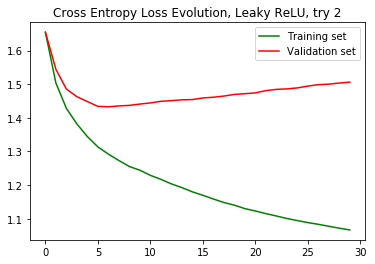

<Figure size 432x288 with 0 Axes>

In [49]:
visualize_costs(training_set_loss_try_2, validation_set_loss_try_2, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 2', save_name='try_2')

In [50]:
accuracy_try_2 = ComputeAccuracy(X_test, y_test, W1_try_2, b1_try_2, W2_try_2, b2_try_2)

The accuracy achieved is 49.77%

In [51]:
accuracy_try_2

49.77

Third try:


100%|██████████| 30/30 [41:07<00:00, 82.25s/it]


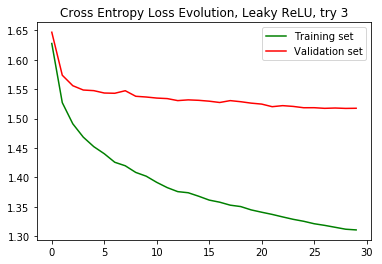

<Figure size 432x288 with 0 Axes>

In [52]:
def try_3(eta=0.02878809988519304, regularization_term=0.001):
    W1_leaky_3, b1_leaky_3, W2_leaky_3, b2_leaky_3 = initialize_weights()

    GD_params = [100, eta, 30]

    W1_leaky_3, b1_leaky_3, W2_leaky_3, b2_leaky_3, training_set_loss_leaky_3, validation_set_loss_leaky_3 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_3, b1_leaky_3, W2_leaky_3, b2_leaky_3,
                                regularization_term,
                                with_leaky_relu=True)

    return W1_leaky_3, b1_leaky_3, W2_leaky_3, b2_leaky_3, training_set_loss_leaky_3, validation_set_loss_leaky_3

"""
Uncomment for third try
"""
W1_try_3, b1_try_3, W2_try_3, b2_try_3, training_set_loss_try_3, validation_set_loss_try_3 = try_3()

visualize_costs(training_set_loss_try_3, validation_set_loss_try_3, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 3', save_name='try_3')

In [53]:
accuracy_try_3 = ComputeAccuracy(X_test, y_test, W1_try_3, b1_try_3, W2_try_3, b2_try_3)

The accuracy achieved on the test set is 52.57%

In [54]:
accuracy_try_3

52.57

Fourth try: Combining Leaky Relu with annealing the learning rate:


100%|██████████| 30/30 [42:58<00:00, 85.95s/it]


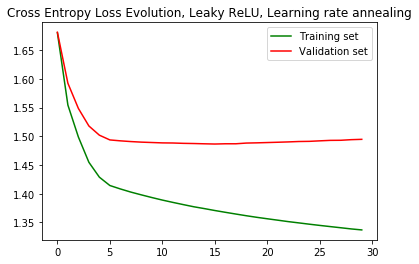

<Figure size 432x288 with 0 Axes>

In [55]:
def try_4(eta=0.018920249916784752, regularization_term=0.001):
    W1_leaky_4, b1_leaky_4, W2_leaky_4, b2_leaky_4 = initialize_weights()

    GD_params = [100, eta, 30]

    W1_leaky_4, b1_leaky_4, W2_leaky_4, b2_leaky_4, training_set_loss_leaky_4, validation_set_loss_leaky_4 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_4, b1_leaky_4, W2_leaky_4, b2_leaky_4,
                                regularization_term,
                                with_annealing=True,
                                with_leaky_relu=True)

    return W1_leaky_4, b1_leaky_4, W2_leaky_4, b2_leaky_4, training_set_loss_leaky_4, validation_set_loss_leaky_4

"""
Uncomment for fourth try
"""
W1_try_4, b1_try_4, W2_try_4, b2_try_4, \
training_set_loss_try_4, validation_set_loss_try_4 = try_4()

visualize_costs(training_set_loss_try_4, validation_set_loss_try_4, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, Learning rate annealing', save_name='try_4')

In [56]:
accuracy_try_4 = ComputeAccuracy(X_test, y_test, W1_try_4, b1_try_4, W2_try_4, b2_try_4)

The accuracy achieved on the test set is 51.04%

In [57]:
accuracy_try_4

51.04

Fifth try: Leaky ReLU and He initialization:


100%|██████████| 30/30 [42:55<00:00, 85.85s/it]


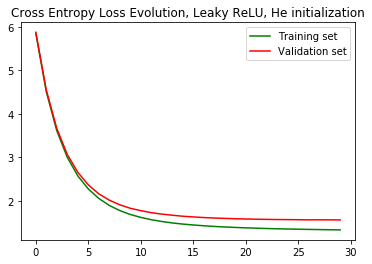

<Figure size 432x288 with 0 Axes>

In [58]:
def try_5(eta=0.018920249916784752, regularization_term=0.001):
    """
    Leaky ReLU with He initialization
    """
    W1_leaky_5, b1_leaky_5, W2_leaky_5, b2_leaky_5 = he_initialization()

    GD_params = [100, eta, 30]

    W1_leaky_5, b1_leaky_5, W2_leaky_5, b2_leaky_5, training_set_loss_leaky_5, validation_set_loss_leaky_5 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_5, b1_leaky_5, W2_leaky_5, b2_leaky_5,
                                regularization_term,
                                with_annealing=False,
                                with_leaky_relu=True)

    return W1_leaky_5, b1_leaky_5, W2_leaky_5, b2_leaky_5, training_set_loss_leaky_5, validation_set_loss_leaky_5

W1_try_5, b1_try_5, W2_try_5, b2_try_5, \
training_set_loss_try_5, validation_set_loss_try_5 = try_5()

visualize_costs(training_set_loss_try_5, validation_set_loss_try_5, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, He initialization', save_name='try_5')

In [59]:
accuracy_try_5 = ComputeAccuracy(X_test, y_test, W1_try_5, b1_try_5, W2_try_5, b2_try_5)

Test set accuracy performance is 52.07%

In [60]:
accuracy_try_5

52.07

Sixth try: Leaky Relu with 100 nodes in the hidden layer:


100%|██████████| 30/30 [43:22<00:00, 86.74s/it]


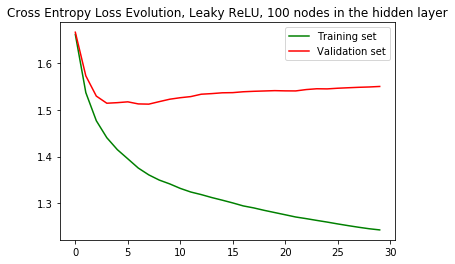

<Figure size 432x288 with 0 Axes>

In [61]:
def try_6(eta=0.018920249916784752, regularization_term=0.001):
    """
    Leaky ReLU with He initialization
    """
    W1_leaky_6, b1_leaky_6, W2_leaky_6, b2_leaky_6 = initialize_weights(m=100)

    GD_params = [100, eta, 30]

    W1_leaky_6, b1_leaky_6, W2_leaky_6, b2_leaky_6, training_set_loss_leaky_6, validation_set_loss_leaky_6 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_6, b1_leaky_6, W2_leaky_6, b2_leaky_6,
                                regularization_term,
                                with_annealing=False,
                                with_leaky_relu=True)

    return W1_leaky_6, b1_leaky_6, W2_leaky_6, b2_leaky_6, training_set_loss_leaky_6, validation_set_loss_leaky_6

"""
Uncomment for sixth try
"""
W1_try_6, b1_try_6, W2_try_6, b2_try_6, \
training_set_loss_try_6, validation_set_loss_try_6 = try_6()

visualize_costs(training_set_loss_try_6, validation_set_loss_try_6, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, 100 nodes in the hidden layer', save_name='try_6')

In [62]:
accuracy_try_6 = ComputeAccuracy(X_test, y_test, W1_try_6, b1_try_6, W2_try_6, b2_try_6)

The accuracy achieved on the test set from this setting is 53.34%

In [63]:
accuracy_try_6

53.34

Seventh try: Leaky ReLU with He initialization AND 100 nodes in the hidden layer

In [64]:
def try_7(eta=0.018920249916784752, regularization_term=0.001):
    """
    Leaky ReLU with jittering
    """
    W1_leaky_7, b1_leaky_7, W2_leaky_7, b2_leaky_7 = he_initialization(m=100)

    GD_params = [100, eta, 30]

    W1_leaky_7, b1_leaky_7, W2_leaky_7, b2_leaky_7, training_set_loss_leaky_7, validation_set_loss_leaky_7 = \
        MiniBatchGDwithMomentum(X_training,
                                  Y_training,
                                  X_validation,
                                  Y_validation,
                                  y_validation,
                                  GD_params,
                                  W1_leaky_7, b1_leaky_7, W2_leaky_7, b2_leaky_7,
                                  regularization_term,
                                  with_annealing=False,
                                  with_leaky_relu=True)

    return W1_leaky_7, b1_leaky_7, W2_leaky_7, b2_leaky_7, training_set_loss_leaky_7, validation_set_loss_leaky_7


100%|██████████| 30/30 [44:30<00:00, 89.01s/it]


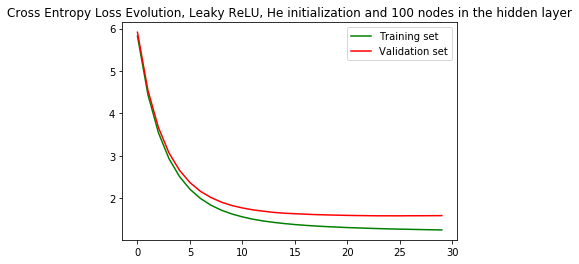

<Figure size 432x288 with 0 Axes>

In [65]:
W1_try_7, b1_try_7, W2_try_7, b2_try_7, \
    training_set_loss_try_7, validation_set_loss_try_7 = try_7()

visualize_costs(training_set_loss_try_7, validation_set_loss_try_7, display=True,
                    title='Cross Entropy Loss Evolution, Leaky ReLU, He initialization and 100 nodes in the hidden layer', save_name='try_7')

In [67]:
accuracy_try_7 = ComputeAccuracy(X_test, y_test, W1_try_7, b1_try_7, W2_try_7, b2_try_7)

Test set accuracy performance of this setting: 53.51%

In [68]:
accuracy_try_7

53.51

Eighth try:

In [72]:
def try_8(eta=0.02878809988519304, regularization_term=0.001):
    W1_leaky_8, b1_leaky_8, W2_leaky_8, b2_leaky_8 = he_initialization()

    GD_params = [100, eta, 30]

    W1_leaky_8, b1_leaky_8, W2_leaky_8, b2_leaky_8, training_set_loss_leaky_8, validation_set_loss_leaky_8 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_8, b1_leaky_8, W2_leaky_8, b2_leaky_8,
                                regularization_term,
                                with_leaky_relu=True)

    return W1_leaky_8, b1_leaky_8, W2_leaky_8, b2_leaky_8, training_set_loss_leaky_8, validation_set_loss_leaky_8


100%|██████████| 30/30 [48:25<00:00, 96.84s/it]


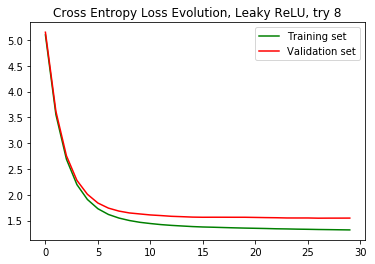

<Figure size 432x288 with 0 Axes>

In [73]:
W1_try_8, b1_try_8, W2_try_8, b2_try_8, training_set_loss_try_8, validation_set_loss_try_8 = try_8()

visualize_costs(training_set_loss_try_8, validation_set_loss_try_8, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 8', save_name='try_8')

In [74]:
accuracy_try_8 = ComputeAccuracy(X_test, y_test, W1_try_8, b1_try_8, W2_try_8, b2_try_8)

Accuracy of this setting 51.68%:

In [75]:
accuracy_try_8

51.68

Ninth try:

In [76]:
def try_9(eta=0.02878809988519304, regularization_term=0.001):
    """
    Best pair of eta, lambda with He initialization AND 100 nodes in the hidden layer
    :return: 
    """
    W1_leaky_9, b1_leaky_9, W2_leaky_9, b2_leaky_9 = he_initialization(m=100)

    GD_params = [100, eta, 30]

    W1_leaky_9, b1_leaky_9, W2_leaky_9, b2_leaky_9, training_set_loss_leaky_9, validation_set_loss_leaky_9 = \
        MiniBatchGDwithMomentum(X_training,
                                Y_training,
                                X_validation,
                                Y_validation,
                                y_validation,
                                GD_params,
                                W1_leaky_9, b1_leaky_9, W2_leaky_9, b2_leaky_9,
                                regularization_term,
                                with_leaky_relu=True)

    return W1_leaky_9, b1_leaky_9, W2_leaky_9, b2_leaky_9, training_set_loss_leaky_9, validation_set_loss_leaky_9


100%|██████████| 30/30 [49:32<00:00, 99.07s/it]


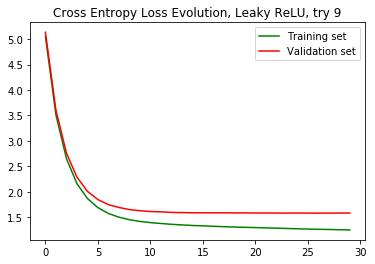

<Figure size 432x288 with 0 Axes>

In [77]:
W1_try_9, b1_try_9, W2_try_9, b2_try_9, training_set_loss_try_9, validation_set_loss_try_9 = try_9()

visualize_costs(training_set_loss_try_9, validation_set_loss_try_9, display=True,
                title='Cross Entropy Loss Evolution, Leaky ReLU, try 9', save_name='try_9')

In [78]:
accuracy_try_9 = ComputeAccuracy(X_test, y_test, W1_try_9, b1_try_9, W2_try_9, b2_try_9)

Accuracy performance of this setting 53.46:

In [79]:
accuracy_try_9

53.46